In [6]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

In [7]:
# Constants
root_dir = './celeba_gan'
N_WORKERS = 4
BATCH_SIZE = 128
IMAGE_SIZE = 64
N_INSTANCES = 10000
NC = 3  # Number of channels (3 for RGB)
NZ = 100  # Length of the latent vector
NGF = 64  # Depth of the feature maps in the generator
NDF = 64  # Depth of the feature maps in the discriminator
EPOCHS = 50
LR = 0.0002  # Learning rate
BETA1 = 0.5  # Beta1 hyperparameter for Adam optimizer
DEVICE = 'mps'

In [8]:
# Data transformations and loading
dataset = dset.ImageFolder(root=root_dir,
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [9]:
# Create dataloader using a subset of the dataset
indices = np.random.permutation(N_INSTANCES)
sampler = SubsetRandomSampler(indices)
dataloader = torch.utils.data.DataLoader(dataset, BATCH_SIZE, sampler=sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


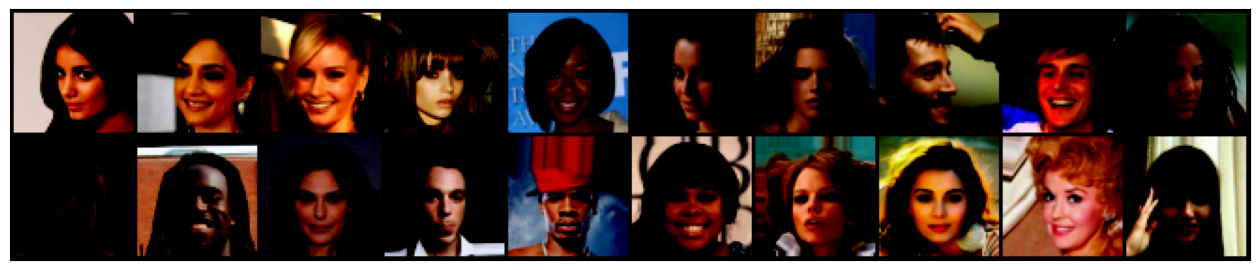

In [10]:
images, _ = next(iter(dataloader))
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:20], 10).permute(1, 2, 0));

In [11]:
def weight_init(model):
    """Initialize weights for Conv and BatchNorm layers."""
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, mean=0.0, std=0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(NZ, NGF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(NGF * 2, NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Initialize models
netG = Generator().to(DEVICE)
netG.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [15]:
netD = Discriminator().to(DEVICE)
netD.apply(weight_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [16]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, NZ, 1, 1, device=DEVICE)
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

In [17]:
def train_discriminator(real_images):
    """Train the discriminator with real and fake images."""
    netD.zero_grad()
    
    # Train with real images
    label = torch.full((real_images.size(0),), 1, dtype=torch.float, device=DEVICE)
    output = netD(real_images).view(-1)
    loss_real = criterion(output, label)
    loss_real.backward()
    D_x = output.mean().item()
    
    # Train with fake images
    noise = torch.randn(real_images.size(0), NZ, 1, 1, device=DEVICE)
    fake_images = netG(noise)
    label.fill_(0)
    output = netD(fake_images.detach()).view(-1)
    loss_fake = criterion(output, label)
    loss_fake.backward()
    D_G_z1 = output.mean().item()
    
    # Update discriminator
    optimizerD.step()
    
    return loss_real + loss_fake, D_x, D_G_z1

In [18]:
def train_generator():
    """Train the generator."""
    netG.zero_grad()
    label = torch.full((BATCH_SIZE,), 1, dtype=torch.float, device=DEVICE)
    noise = torch.randn(BATCH_SIZE, NZ, 1, 1, device=DEVICE)
    fake_images = netG(noise)
    output = netD(fake_images).view(-1)
    loss = criterion(output, label)
    loss.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()
    return loss, D_G_z2

In [19]:
def train_GAN(dataloader, epochs=EPOCHS):
    """Train the GAN for a number of epochs."""
    img_list, G_losses, D_losses, real_scores, fake_scores = [], [], [], [], []
    
    for epoch in range(1, epochs + 1):
        for i, (data, _) in enumerate(dataloader):
            real_images = data.to(DEVICE)
            D_loss, D_x, D_G_z1 = train_discriminator(real_images)
            G_loss, D_G_z2 = train_generator()
            
            # Save losses for plotting
            if i % (len(dataloader) // 4) == 0:
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())
                real_scores.append(D_x)
                fake_scores.append(D_G_z1)
                print(f'[{epoch}/{epochs}] [{i}/{len(dataloader)}] '
                      f'Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f} '
                      f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
                
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
    return img_list, G_losses, D_losses, real_scores, fake_scores

In [20]:
img_list, G_losses, D_losses, real_scores, fake_scores = train_GAN(dataloader, EPOCHS)

[1/50] [0/79] Loss_D: 1.4423 Loss_G: 5.2180 D(x): 0.6591 D(G(z)): 0.5655 / 0.0106
[1/50] [19/79] Loss_D: 0.2568 Loss_G: 13.2446 D(x): 0.9442 D(G(z)): 0.1287 / 0.0000
[1/50] [38/79] Loss_D: 0.0773 Loss_G: 24.2286 D(x): 0.9604 D(G(z)): 0.0000 / 0.0000
[1/50] [57/79] Loss_D: 0.0108 Loss_G: 12.8534 D(x): 0.9912 D(G(z)): 0.0002 / 0.0001
[1/50] [76/79] Loss_D: 0.0026 Loss_G: 42.4633 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[2/50] [0/79] Loss_D: 0.0063 Loss_G: 42.2600 D(x): 0.9943 D(G(z)): 0.0000 / 0.0000
[2/50] [19/79] Loss_D: 0.0008 Loss_G: 42.0124 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[2/50] [38/79] Loss_D: 0.0003 Loss_G: 41.6771 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[2/50] [57/79] Loss_D: 0.0007 Loss_G: 41.4376 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[2/50] [76/79] Loss_D: 0.0013 Loss_G: 41.3288 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[3/50] [0/79] Loss_D: 0.0002 Loss_G: 41.4615 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[3/50] [19/79] Loss_D: 0.0001 Loss_G: 41.2475 D(x): 0.9999 D(G(z)): 0.0000 / 0.0

KeyboardInterrupt: 

NameError: name 'G_losses' is not defined

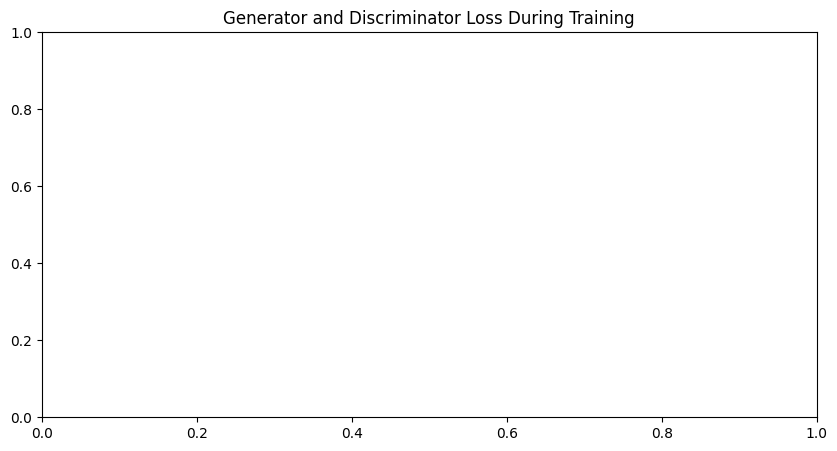

In [21]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Visualizing the Real images


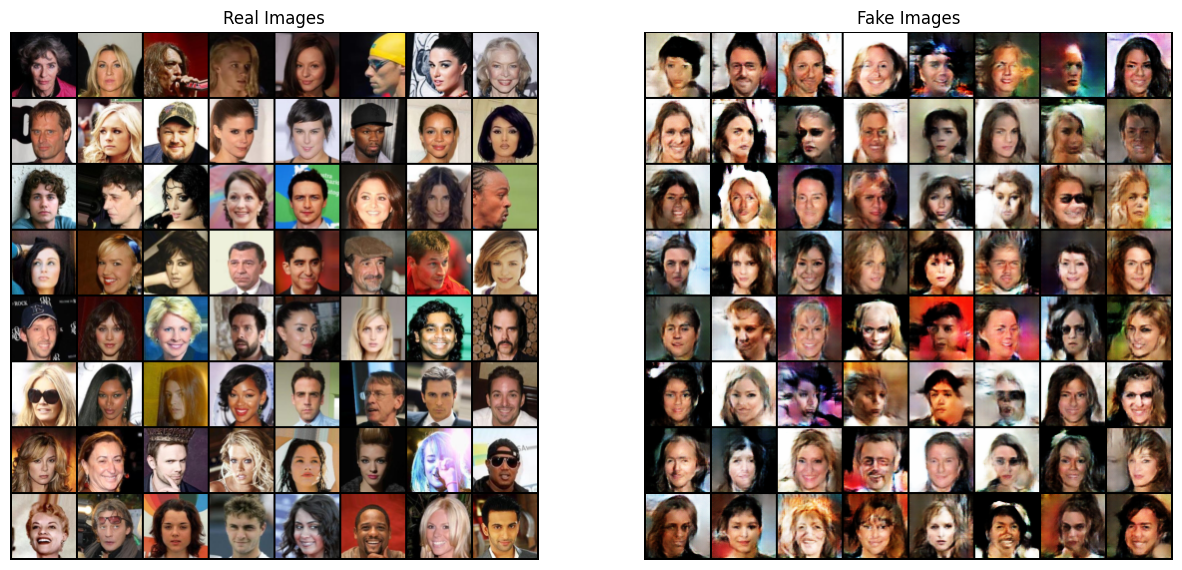

In [30]:
real_batch = None
for images,_ in dataloader : 
    real_batch = images
    break
    
print("Visualizing the Real images")
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE)[:64],padding=2,normalize=True).cpu() ,(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [31]:
# Save the models
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')